## NOTE: Note that the GR6J model was simulated using R and then the predicted time series was imported here for the modeling process.

In [ ]:
 import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import concatenate
import math
from math import sqrt
import random
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib import pylab as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

from tensorflow.keras.layers import Flatten

import joblib
from google.colab import files
import matplotlib.dates as mdates


In [ ]:
import tensorflow as tf

seed = 311
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# To enforce determinism on operations
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Prof Mwangi/Qdaily_1FG01_Yala_2014_2020.xlsx')

daily = data.iloc[:, [-4, -3, -2]]

discharge = daily.iloc[:1461, 2].to_numpy()
plui = daily.iloc[:1461, 0].to_numpy()
etp = daily.iloc[:1461, 1].to_numpy()

discharge1 = daily.iloc[1461:2191, 2].to_numpy()
plui1 = daily.iloc[1461:2191, 0].to_numpy()
etp1 = daily.iloc[1461:2191, 1].to_numpy()

In [ ]:
discharge[0]

np.float64(34.25915)

In [ ]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR6J

In [ ]:
GR6J = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_cal_yala.xlsx')
GR6J_val = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_val_yala.xlsx')

simGR6J = GR6J.to_numpy()
simGR6J_val = GR6J_val.to_numpy()

simGR6J = simGR6J.flatten()
simGR6J_val = simGR6J_val.flatten()

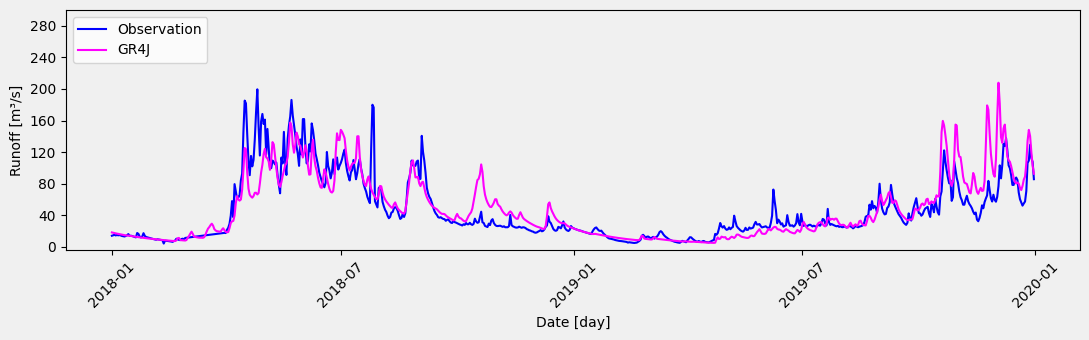

In [ ]:
# Generate dates
time1 = np.datetime64('2018-01-01')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, simGR6J_val, 'magenta', label='GR4J', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-4, 300)
ax.set_yticks(np.arange(0, 300, 40))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J.jpeg")

ax.grid(False)

# Show plot
plt.show()


In [ ]:
#Calibration
simGR4J = simGR6J.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], simGR4J[1:]))
print('rmse=',calculate_rmse(discharge[1:], simGR4J[1:]))
print('r2=',calculate_r2(discharge[1:], simGR4J[1:]))

nashe= 0.56008892816591
rmse= 14.879631129723975
r2= 0.6064733407486219


In [ ]:
#Validation
simGR4J_val = simGR6J_val.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge1[1:], simGR4J_val[1:]))
print('rmse=',calculate_rmse(discharge1[1:], simGR4J_val[1:]))
print('r2=',calculate_r2(discharge1[1:], simGR4J_val[1:]))

nashe= 0.6843335380635556
rmse= 22.11890241857086
r2= 0.7156824735950033


In [ ]:
Residu =  discharge - simGR6J
Residu1 = discharge1 - simGR6J_val

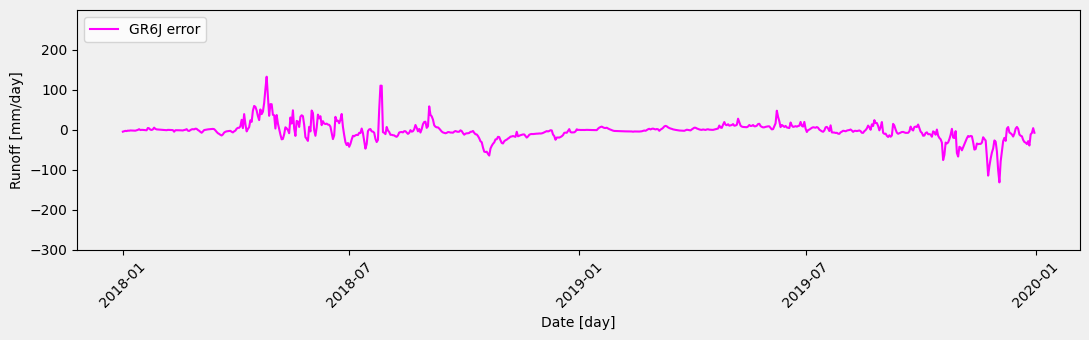

In [ ]:
# Generate dates
time1 = np.datetime64('2018-01-01')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
#ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time,Residu1, 'magenta', label='GR6J error', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-300, 300)
ax.set_yticks(np.arange(-300, 300, 100))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()


#files.download("Cauqueness_GR4J.jpeg")

# Show plot
plt.show()


GR6J_LSTM

In [ ]:
pip install optuna

In [ ]:
# ==========================================================
# 🔧 0️⃣ Imports & general settings
# ==========================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import copy
import optuna
import matplotlib.pyplot as plt
import random

# reproducibility
SEED = 142
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================================
# 1️⃣ Nash–Sutcliffe Efficiency
# ==========================================================
def nash_sutcliffe_efficiency(obs, sim):
    obs = np.array(obs)
    sim = np.array(sim)
    denom = np.sum((obs - np.mean(obs)) ** 2)
    if denom == 0:
        return -np.inf
    return 1 - np.sum((obs - sim) ** 2) / denom

# ==========================================================
# 2️⃣ Data + Lag features
# ==========================================================
lag = 2  # adjustable

data_train = pd.DataFrame({
    'Qsim': simGR4J,
    'plui': plui,
    'etp': etp,
    'target': Residu
})

data_test = pd.DataFrame({
    'Qsim': simGR4J_val,
    'plui': plui1,
    'etp': etp1,
    'target': Residu1
})

data = pd.concat([data_train, data_test], ignore_index=True)

# --- create lag features if lag >= 1, else keep raw variables ---
if lag >= 1:
        for f in ['Qsim', 'plui', 'etp']:
            for l in range(1, lag + 1):
                data[f'{f}_lag{l}'] = data[f].shift(l)
        data = data.dropna().reset_index(drop=True)
else:
        # lag == 0 -> keep raw columns (no shift)
        data = data.reset_index(drop=True)

# ==========================================================
# 3️⃣ Splitting and scaling — also returns X_cols and scalers
# ==========================================================
def Make_tidydata_for_lstm_once(data_df, train_size=1280):
    df = data_df.copy().reset_index(drop=True)
    if train_size >= len(df):
        raise ValueError("train_size too large for dataset size.")

    train_df = df.iloc[:train_size].copy().reset_index(drop=True)
    val_df = df.iloc[train_size:].copy().reset_index(drop=True)

    # automatically detect all lag columns
    X_cols = [
    'Qsim', 'plui', 'etp'
    ] + [c for c in df.columns if c.startswith("Qsim_lag")
                         or c.startswith("plui_lag")
                         or c.startswith("etp_lag")]
    y_col = 'target'

    # keep unscaled copies for verification
    train_df['target_orig'] = train_df[y_col].values
    val_df['target_orig'] = val_df[y_col].values

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    scaler_X.fit(train_df[X_cols])
    scaler_y.fit(train_df[[y_col]])

    train_df[X_cols] = scaler_X.transform(train_df[X_cols])
    val_df[X_cols] = scaler_X.transform(val_df[X_cols])
    train_df[[y_col]] = scaler_y.transform(train_df[[y_col]])
    val_df[[y_col]] = scaler_y.transform(val_df[[y_col]])

    return train_df, val_df, scaler_X, scaler_y, X_cols

TRAIN_SIZE = 1461
train_df, val_df, scaler_X, scaler_y, X_cols = Make_tidydata_for_lstm_once(data, train_size=TRAIN_SIZE)

# ==========================================================
# 4️⃣ DataLoader creation — builds the correct shape (N, seq_len=1, input_dim)
# ==========================================================
def data_loading_from_df(df, X_cols=None, y_col='target', batch_size=None, shuffle=False):
    if X_cols is None:
        X_cols = [c for c in df.columns if c.endswith("_lag")]
    X_np = df[X_cols].values.astype(np.float32)
    # reshape for LSTM : (N, seq_len=1, input_dim=len(X_cols))
    X = torch.tensor(X_np.reshape(-1, 1, X_np.shape[1])).float()
    y = torch.tensor(df[y_col].values.astype(np.float32)).float().reshape(-1, 1)
    dataset = TensorDataset(X, y)
    if batch_size is None:
        batch_size = len(dataset)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# ==========================================================
# 5️⃣ Prediction function (compatible with LSTM input shape)
# ==========================================================
def predict_all(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            y_pred = model(Xb)            # returns (batch, 1)
            preds.append(y_pred.cpu())
            trues.append(yb)
    if not preds:
        return np.array([]), np.array([])
    preds = torch.cat(preds).numpy().flatten()
    trues = torch.cat(trues).numpy().flatten()
    return preds, trues

# ==========================================================
# 6️⃣ Simple LSTM model — initialized with dynamic input_dim
# ==========================================================
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # take the last temporal output
        return out

# ==========================================================
# 7️⃣ Training a given model — automatically detects input_dim
# ==========================================================
def train_test_loop_from_dfs(train_df, val_df, scaler_y,
                             epochs=200, hidden_dim=64, lr=1e-3, batch_size=None, trial=None):
    # use columns already prepared in Make_tidydata_for_lstm_once
    global X_cols
    X_cols_local = X_cols
    input_dim = len(X_cols_local)


    train_loader = data_loading_from_df(train_df, X_cols=X_cols_local, batch_size=batch_size, shuffle=True)
    val_loader = data_loading_from_df(val_df, X_cols=X_cols_local, batch_size=batch_size, shuffle=False)

    model = SimpleLSTM(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_nse = -np.inf
    best_state = None

    for epoch in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(Xb), yb)
            loss.backward()
            optimizer.step()

        # Validation
        y_val_pred_s, y_val_true_s = predict_all(model, val_loader)
        if len(y_val_pred_s) == 0:
            continue
        y_val_pred = scaler_y.inverse_transform(y_val_pred_s.reshape(-1, 1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_true_s.reshape(-1, 1)).flatten()
        nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

        if nse_val > best_val_nse:
            best_val_nse = nse_val
            best_state = copy.deepcopy(model.state_dict())

        if trial:
            trial.report(nse_val, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    if best_state is not None:
        model.load_state_dict(best_state)

    # final train/val NSE
    y_train_pred_s, y_train_true_s = predict_all(model, train_loader)
    y_val_pred_s, y_val_true_s = predict_all(model, val_loader)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_s.reshape(-1, 1)).flatten()
    y_train_true = scaler_y.inverse_transform(y_train_true_s.reshape(-1, 1)).flatten()
    y_val_pred = scaler_y.inverse_transform(y_val_pred_s.reshape(-1, 1)).flatten()
    y_val_true = scaler_y.inverse_transform(y_val_true_s.reshape(-1, 1)).flatten()

    nse_train = nash_sutcliffe_efficiency(y_train_true, y_train_pred)
    nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

    return model, y_train_pred, y_val_pred, nse_train, nse_val

# ==========================================================
# 8️⃣ Optuna optimization
# ==========================================================
best_model_state_global = None
best_val_global = -np.inf
best_params_global = None

def objective(trial):
    global best_model_state_global, best_val_global, best_params_global

    hidden = trial.suggest_categorical("hidden_dim", [16, 32, 64, 128, 256, 512])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])
    epochs = trial.suggest_categorical("epochs", list(range(50,700,50)))
    batch = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256, 512])

    try:
        model, _, _, _, nse_val = train_test_loop_from_dfs(train_df, val_df, scaler_y,
                                                           epochs=epochs, hidden_dim=hidden, lr=lr, batch_size=batch, trial=trial)
    except optuna.TrialPruned:
        raise
    except Exception as e:
        print(f"Trial failed: {e}")
        return -np.inf

    if nse_val > best_val_global:
        best_val_global = nse_val
        best_model_state_global = copy.deepcopy(model.state_dict())
        best_params_global = {"hidden_dim": hidden, "lr": lr, "epochs": epochs, "batch_size": batch}
    return nse_val

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("\n🎯 Best Optuna params:", study.best_params)
print("✅ Best tracked params:", best_params_global)
print(f"✅ Best Validation NSE: {best_val_global:.4f}")

# ==========================================================
# 9️⃣ Restore best model
# ==========================================================
best_h = best_params_global["hidden_dim"]
best_lr = best_params_global["lr"]
best_ep = best_params_global["epochs"]
best_bs = best_params_global["batch_size"]

# rebuild model with correct input_dim
input_dim_final = len(X_cols)
model_final = SimpleLSTM(input_dim=input_dim_final, hidden_dim=best_h).to(device)
model_final.load_state_dict(best_model_state_global)

# ==========================================================
# 🔟 Final TRAIN and TEST predictions
# ==========================================================
train_loader_final = data_loading_from_df(train_df, X_cols=X_cols, batch_size=best_bs, shuffle=False)
val_loader_final   = data_loading_from_df(val_df,   X_cols=X_cols, batch_size=best_bs, shuffle=False)

y_train_pred_s, _ = predict_all(model_final, train_loader_final)
y_val_pred_s, _   = predict_all(model_final, val_loader_final)

res_pred_train = scaler_y.inverse_transform(y_train_pred_s.reshape(-1, 1)).flatten()
res_pred_test  = scaler_y.inverse_transform(y_val_pred_s.reshape(-1, 1)).flatten()
y_train_true = train_df['target_orig'].values
y_val_true   = val_df['target_orig'].values

nse_train_final = nash_sutcliffe_efficiency(y_train_true, res_pred_train)
nse_val_final   = nash_sutcliffe_efficiency(y_val_true, res_pred_test)

print("\n📊 Final NSE scores:")
print(f"➡ Train NSE: {nse_train_final:.4f}")
print(f"➡ Test  NSE: {nse_val_final:.4f}")


[I 2025-11-17 23:25:57,252] A new study created in memory with name: no-name-9c29c5ed-e891-4704-a95e-8b8afe23fb6c
[I 2025-11-17 23:26:49,252] Trial 0 finished with value: 0.15437191724777222 and parameters: {'hidden_dim': 32, 'lr': 0.001, 'epochs': 500, 'batch_size': 512}. Best is trial 0 with value: 0.15437191724777222.
[I 2025-11-17 23:27:31,716] Trial 1 finished with value: 0.16375505924224854 and parameters: {'hidden_dim': 128, 'lr': 0.01, 'epochs': 450, 'batch_size': 512}. Best is trial 1 with value: 0.16375505924224854.
[I 2025-11-17 23:28:46,499] Trial 2 finished with value: 0.14505380392074585 and parameters: {'hidden_dim': 32, 'lr': 0.01, 'epochs': 200, 'batch_size': 16}. Best is trial 1 with value: 0.16375505924224854.
[I 2025-11-17 23:30:58,452] Trial 3 finished with value: 0.15465956926345825 and parameters: {'hidden_dim': 64, 'lr': 0.01, 'epochs': 600, 'batch_size': 32}. Best is trial 1 with value: 0.16375505924224854.
[I 2025-11-17 23:32:06,235] Trial 4 finished with valu


🎯 Best Optuna params: {'hidden_dim': 512, 'lr': 0.01, 'epochs': 550, 'batch_size': 16}
✅ Best tracked params: {'hidden_dim': 512, 'lr': 0.01, 'epochs': 550, 'batch_size': 16}
✅ Best Validation NSE: 0.1763

📊 Final NSE scores:
➡ Train NSE: 0.1631
➡ Test  NSE: 0.1763


In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(Residu1[2:], res_pred_test)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(Residu1[2:], res_pred_test)
print('RMSE =', rmse)

r2 = calculate_r2(Residu1[2:], res_pred_test)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.17625832253736973
RMSE = 19.97252176371524
R² = 0.19029168261038196


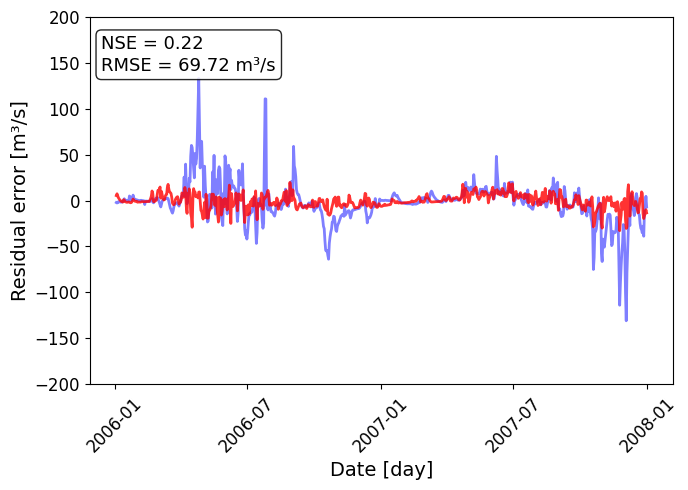

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Generate dates
time1 = np.datetime64('2006-01-03')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 5))

# Plot observed and simulated discharge
ax.plot(time, Residu1[2:], color='b', alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", linewidth=2)
ax.plot(time, res_pred_test, color='red', alpha=0.8, label='Prediction (WKAN)', linewidth=2)

# Annotation
plt.text(0.02, 0.95, f"NSE = {0.22}\nRMSE = {69.72} m³/s",
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=12)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Residual error [m³/s]', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-200, 200)
ax.set_yticks(np.arange(-200, 201, 50))

# Add legend
#ax.legend(fontsize=13)

# Remove grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Res_KAN.jpeg", format='jpeg', dpi=700)

# Télécharger le fichier dans Google Colab
from google.colab import files
#files.download('Res_KAN.jpeg')

# Show plot
plt.show()


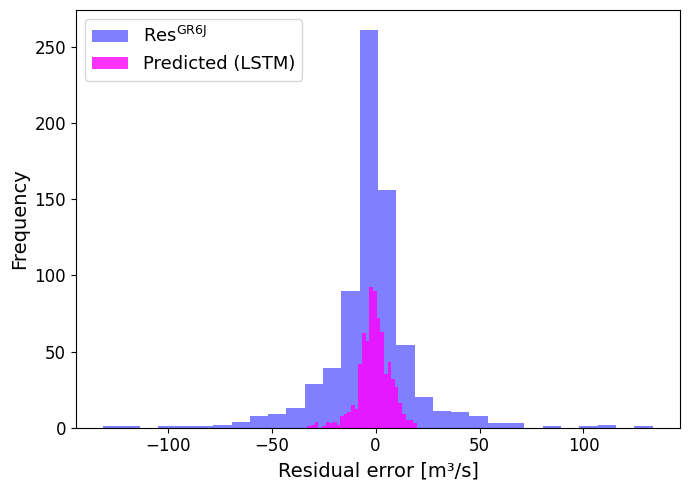

In [ ]:
# Plot
plt.figure(figsize=(7, 5))
plt.hist(Residu1, bins=30, alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", color='b')
plt.hist(res_pred_test, bins=30, alpha=0.8, label='Predicted (LSTM)', color='magenta')

# Labels
plt.xlabel('Residual error [m³/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.legend(loc='upper left', fontsize=13)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

# Save figure
plt.savefig("His_LSTM_yala.jpeg", format='jpeg', dpi=700)
#files.download('His_LSTM_yala.jpeg')

plt.show()


In [ ]:
final_pred = simGR6J[2:] + res_pred_train[:-2]
final_pred1 = simGR6J_val[2:] + res_pred_test

In [ ]:
# Training Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge[2:], final_pred)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[2:], final_pred)
print('RMSE =', rmse)

r2 = calculate_r2(discharge[2:], final_pred )
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.6342985114940688
RMSE = 13.5713128387901
R² = 0.6472303327018201


In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge1[2:], final_pred1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[2:], final_pred1)
print('RMSE =', rmse)

r2 = calculate_r2(discharge1[2:], final_pred1)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.7427571616847113
RMSE = 19.97252176371524
R² = 0.7488737904029631


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

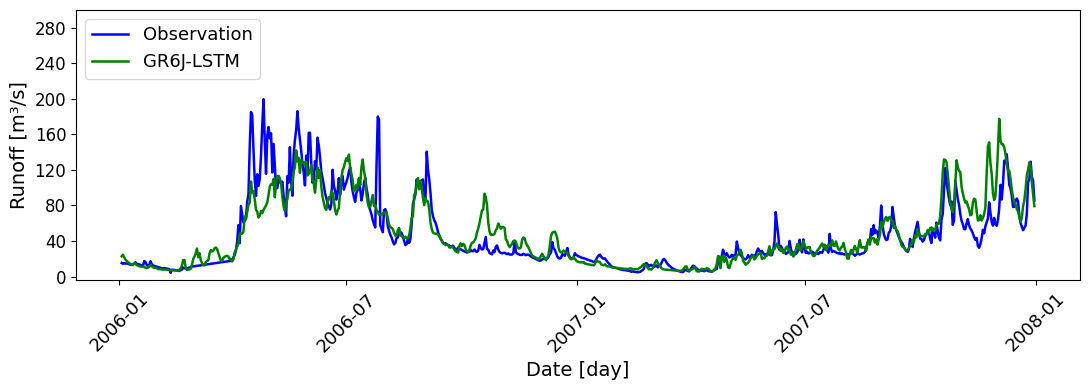

In [ ]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Generate dates
time1 = np.datetime64('2006-01-03')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11, 4))

# Plot observed and simulated discharge
ax.plot(time, discharge1[2:], 'b', label='Observation', linewidth=1.8)
ax.plot(time, final_pred1, 'green', label='GR6J-LSTM', linewidth=1.8)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=13)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]', fontsize=14)
ax.tick_params(axis='y', labelcolor='black', labelsize=12)
ax.set_ylim(-4, 300)
ax.set_yticks(np.arange(0, 300, 40))

# Add legend
ax.legend(loc='upper left', fontsize=13)

# Disable grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("GR6J_LSTM_yala.jpeg", format='jpeg', dpi=700)

#files.download('GR6J_LSTM_yala.jpeg')

# Show plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory to an Excel file
df_mean_trajectory = pd.DataFrame({'GR6J_LSTM_yala': final_pred1})

# Save to an Excel file
df_mean_trajectory.to_excel('GR6J_LSTM_yala.xlsx', index=False)

# Download the file in Google Colab
#files.download('GR6J_LSTM_yala.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(t) GR6J_LSTM

Nash-Sutcliffe Efficiency (NSE): 0.6179228885148795
RMSE = 13.871838010161454
R² = 0.6186875064756787

Nash-Sutcliffe Efficiency (NSE): 0.7350778701466494
RMSE = 20.268442426401485
R² = 0.7366089873347003


(t) GR6J_LSTM_P_PET

Nash-Sutcliffe Efficiency (NSE): 0.6342985114940688
RMSE = 13.5713128387901
R² = 0.6472303327018201

Nash-Sutcliffe Efficiency (NSE): 0.7427571616847113
RMSE = 19.97252176371524
R² = 0.7488737904029631